In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import silhouette_score
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, aggp_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 50
c_capacity = 100
max_resources = device_number * avg - 100

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
X_dim = [-10, 110]
Y_dim = [-60, 60]
centers = 40

H, bins = get_lognorm_hist()
prim_df, coords, c_coords, base_col, slot_columns, sums = setup_topology(H, max_resources, c_capacity, centers,
                                                                         X_dim_range, Y_dim_range, device_number - 1,
                                                                         seed)

eval_matrix = {}

In [3]:
prim_df

,x,y,latency,type,weight,base,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,19.383905,7.406120,0.000000,coordinator,0,9223372036854775807,100,100,100,100,100,100,100,100,100,100,100,100
1,67.743232,-14.007158,52.888118,worker,1,9223372036854775807,50,49,52,47,46,48,34,39,56,69,218,0
2,5.220579,-15.467092,26.903228,worker,1,9223372036854775807,50,52,54,55,48,51,46,34,27,30,16,11
3,43.521014,41.129903,41.471599,worker,1,9223372036854775807,50,49,53,60,55,69,66,29,61,25,59,21
4,14.195029,1.412734,7.927491,worker,2,9223372036854775807,50,51,50,44,41,65,33,34,66,39,22,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,1,9223372036854775807,50,51,54,48,52,59,52,30,43,30,24,4
997,39.672067,34.499402,33.847532,worker,1,9223372036854775807,50,52,53,60,52,40,33,34,26,62,19,212
998,40.609309,23.985392,26.933066,worker,1,9223372036854775807,50,49,54,48,66,41,37,66,39,28,72,7
999,31.878351,34.859971,30.163307,worker,2,9223372036854775807,50,49,52,51,43,66,42,94,31,19,62,0


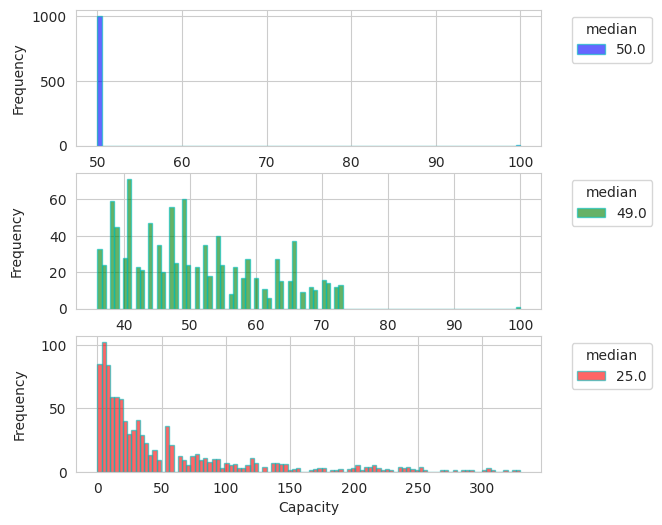

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

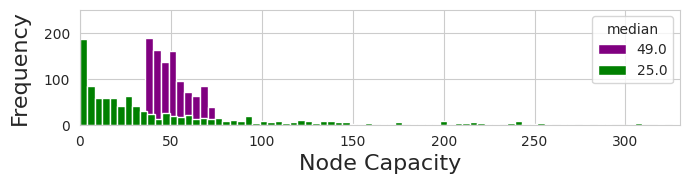

In [5]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


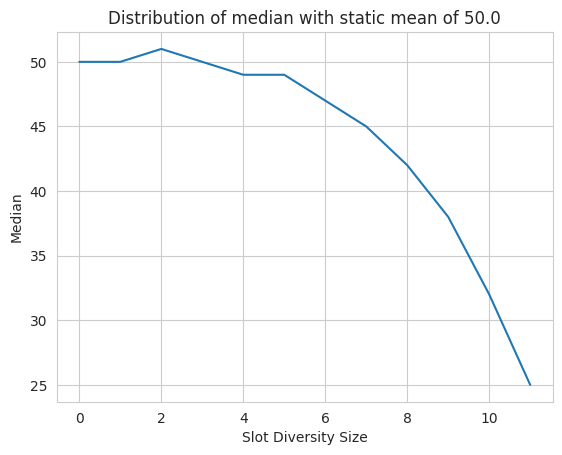

In [6]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

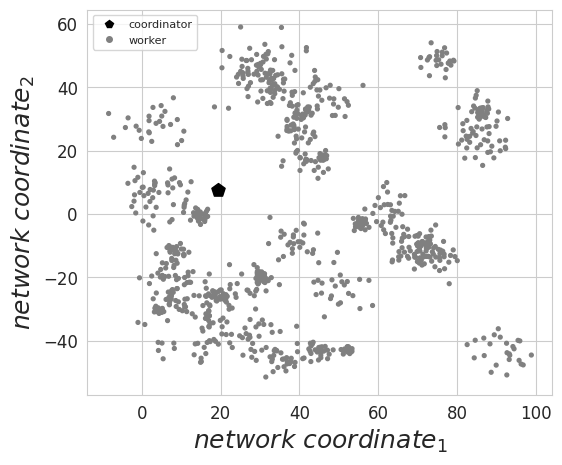

In [7]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

tcolors = {"coordinator": "red", "worker": "grey"}
scat2 = prim_df.plot.scatter(ax=ax1, x="x", y="y", c=prim_df["type"].map(tcolors),
                             s=prim_df["capacity_" + str(100)] * 0.15)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
ax1.scatter(coords[0, 0], coords[0, 1], color='grey')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_plain.svg", bbox_inches="tight")

#plot coordinators
ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')
ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
#ax1.set_title('NES Topology in a Cost Space')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")
plt.show()

In [8]:
# Compute DBSCAN
#db = DBSCAN(eps=2, min_samples=2).fit(coords)
#labels = db.labels_

#bandwidth = cluster.estimate_bandwidth(coords, quantile=0.08)
#if bandwidth==0:
#    bandwidth = None
#cluster_alg = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(coords)
#labels = cluster_alg.labels_

In [9]:
def get_max_by_thresh(elements, threshold):
    max_k = np.argmax(elements)
    min_t = max(0, elements[max_k]-threshold)
    print(min_t)
    for i in range(len(elements) - 1, -1, -1):
        if elements[i] >= min_t:
            return i
        i += i
    return max_k

5
10
15
20
25
30
35
40
[0.4366208489016169, 0.4578903649217423, 0.49992119195341034, 0.5108058793595069, 0.5299915524594493, 0.5267786941386162, 0.5009227602975688, 0.4841569002362528, 0.5183732388175919, 0.5089759274551251, 0.5117896205451166, 0.5105253622412232, 0.5293334983994091, 0.5168366205208105, 0.5165437266976227, 0.5328298970637009, 0.5141888446038513, 0.5166973296098755, 0.508212798745317, 0.49082279488661057, 0.5001087379532659, 0.513173374582429, 0.492597708410025, 0.47799126712529283, 0.4678521377629234, 0.47591984822325606, 0.4667828622462073, 0.4670538328025685, 0.45841087810116826, 0.46154585240155954, 0.463681107145512, 0.466978325948181, 0.4696620925520523, 0.4654845320601953, 0.46592072074580115, 0.4675757861690655, 0.4588597782992966, 0.46048437791823976, 0.4618643775887571]
0.4828298970637009
Optimal k is  22


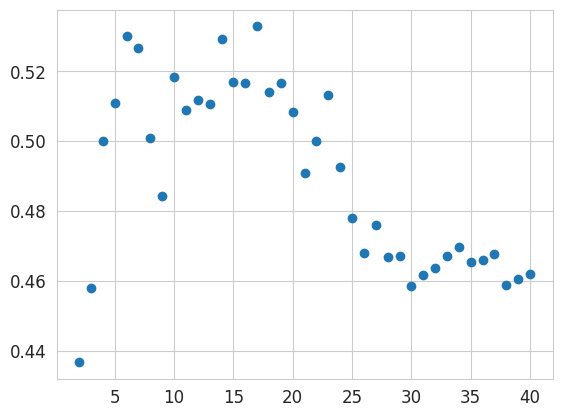

In [10]:
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

#opt_k = np.argmax(sil)
#opt_k = kmin + opt_k
opt_k = get_max_by_thresh(sil, 0.05)
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)

prim_df["cluster"] = labels
prim_df.loc[0, "cluster"] = -1

In [11]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 22
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

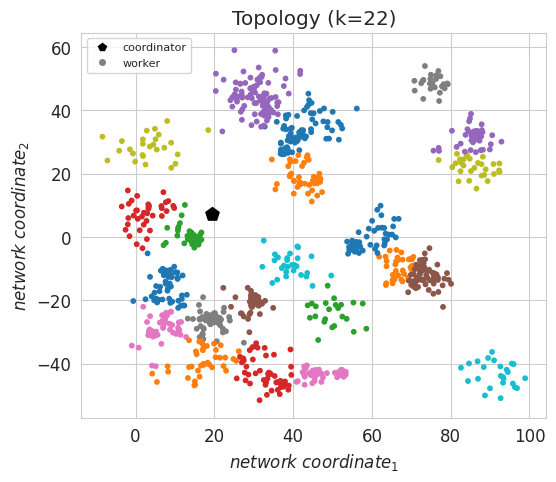

In [12]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/sim" + str(device_number - 1) + "_" + str(no_clusters) + ".svg", bbox_inches="tight")
plt.title('Topology (k=' + str(no_clusters) + ")")

plt.show()

### Experiment 1: Send all data directly to coordinator


In [13]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

      latency_distribution  received_packets
0                 0.000000            1000.0
1                52.888118               0.0
2                26.903228               0.0
3                41.471599               0.0
4                 7.927491               0.0
...                    ...               ...
996              11.652010               0.0
997              33.847532               0.0
998              26.933066               0.0
999              30.163307               0.0
1000             36.664622               0.0

[1001 rows x 2 columns]


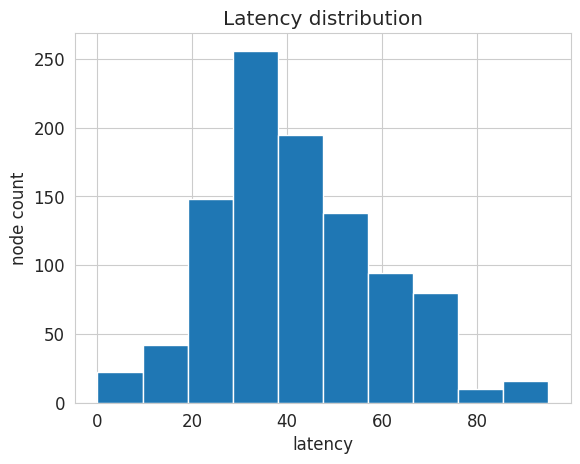

In [14]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [15]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 1001 = 0.0999 %


### Experiment 1: LEACH Protocol

In [16]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = no_clusters

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  22
[586, 34, 440, 495, 592, 16, 212, 474, 833, 504, 844, 285, 670, 831, 165, 36, 534, 502, 336, 78, 256, 976]


In [17]:
df_stats

,latency_distribution,received_packets
0,0.000000,22.0
1,54.757736,0.0
2,54.558520,0.0
3,42.408515,0.0
4,47.136748,0.0
...,...,...
996,43.136748,0.0
997,33.303551,0.0
998,35.791942,0.0
999,38.591635,0.0


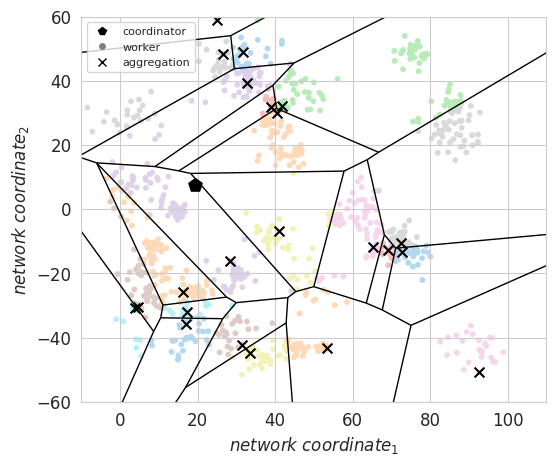

In [18]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, aggp_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/sim_1000/leach.svg")
plt.show()

count    1001.000000
mean       53.240309
std        17.517942
min         0.000000
25%        40.558520
50%        49.427215
75%        62.121123
max       107.639423
Name: latency_distribution, dtype: float64


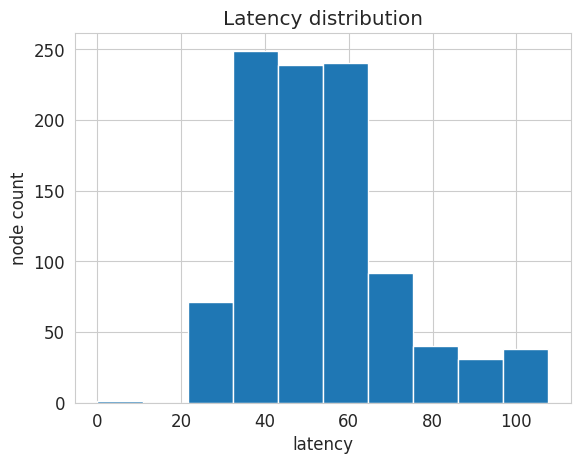

In [19]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [20]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Centroid Grouping

In [29]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

eval_name = "nemo_rc"
df_dict_rdm, eval_matrix[eval_name], agg_dict_rdm, new_paths_rdm = evaluate_nemo(prim_df, coords, centroids, W, L,
                                                                                    [base_col] + slot_columns, iterations, weighting="centroid")

Starting nemo for base with centroid
Starting nemo for capacity_100 with centroid
Starting nemo for capacity_90 with centroid
Starting nemo for capacity_80 with centroid
Starting nemo for capacity_70 with centroid
Starting nemo for capacity_60 with centroid
Starting nemo for capacity_50 with centroid
Starting nemo for capacity_40 with centroid
Starting nemo for capacity_30 with centroid
Starting nemo for capacity_20 with centroid
Starting nemo for capacity_10 with centroid
Starting nemo for capacity_5 with centroid
Starting nemo for capacity_1 with centroid


In [30]:
df_dict_rdm["base"][df_dict_rdm["base"]["cluster"]==0]

,cluster,base,parent,route,weight
3,0,9223372036854775807,512,"[512, 0]",1
12,0,9223372036854775807,512,"[512, 0]",2
37,0,9223372036854775807,512,"[512, 0]",1
58,0,9223372036854775807,512,"[512, 0]",2
74,0,9223372036854775807,512,"[512, 0]",1
...,...,...,...,...,...
951,0,9223372036854775807,512,"[512, 0]",2
980,0,9223372036854775807,512,"[512, 0]",1
987,0,9223372036854775807,512,"[512, 0]",1
997,0,9223372036854775807,512,"[512, 0]",1


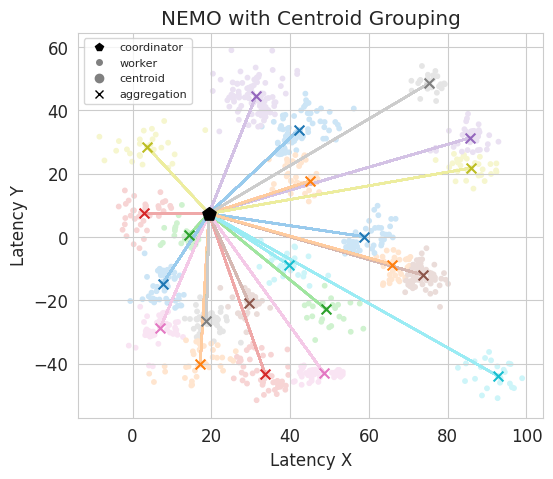

In [31]:
fig = plt.figure(figsize=(6, 5))
lval = 0.2

f1 = fig.add_subplot(111)
util.plot(f1, new_paths_rdm["base"], agg_dict_rdm["base"], c_coords, None, coords, colors, labels, lval=lval,
          print_centroids=False)

plt.xlabel('Latency X')
plt.ylabel('Latency Y')
plt.title('NEMO with Centroid Grouping')

plt.show()

Distribution of workload:  2.2977 %


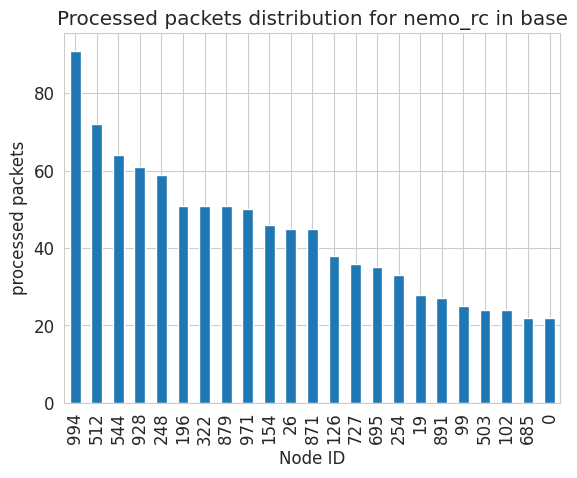

In [32]:
eval_col = list(eval_matrix[eval_name])[0]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [33]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

slot_col = "capacity_1"
med_label = first_med_label
eval_name = "nemo_dc"
df_dict_flat, eval_matrix[eval_name], agg_dict_flat, new_paths_flat = evaluate_nemo(prim_df, coords, centroids, W, L,
                                                                                    ["base"] + slot_columns, iterations, weighting="spring")

Starting nemo for base with spring
Starting nemo for capacity_100 with spring
Starting nemo for capacity_90 with spring
Starting nemo for capacity_80 with spring
Starting nemo for capacity_70 with spring
Starting nemo for capacity_60 with spring
Starting nemo for capacity_50 with spring
Starting nemo for capacity_40 with spring
Starting nemo for capacity_30 with spring
Starting nemo for capacity_20 with spring
Starting nemo for capacity_10 with spring
Starting nemo for capacity_5 with spring
Starting nemo for capacity_1 with spring


In [34]:
reassigned_clussters = util.get_diff(agg_dict_flat["base"], agg_dict_flat[slot_col])
print(reassigned_clussters)

[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 19, 20, 21]


In [35]:
#Test to see if there are any overloaded nodes, result should be empty
df_overloaded = df_dict_flat[slot_col].groupby(['parent'])['weight'].sum()
df_capacity = df_dict_flat[slot_col][slot_col][df_overloaded.index]
result = pd.concat([df_capacity, df_overloaded], axis=1).reindex(df_overloaded.index)
result.columns = ["capacity", "load"]
result["delta"] = result["capacity"] - result["load"]
result[result["delta"] < 0]

,capacity,load,delta
parent,,,


In [36]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

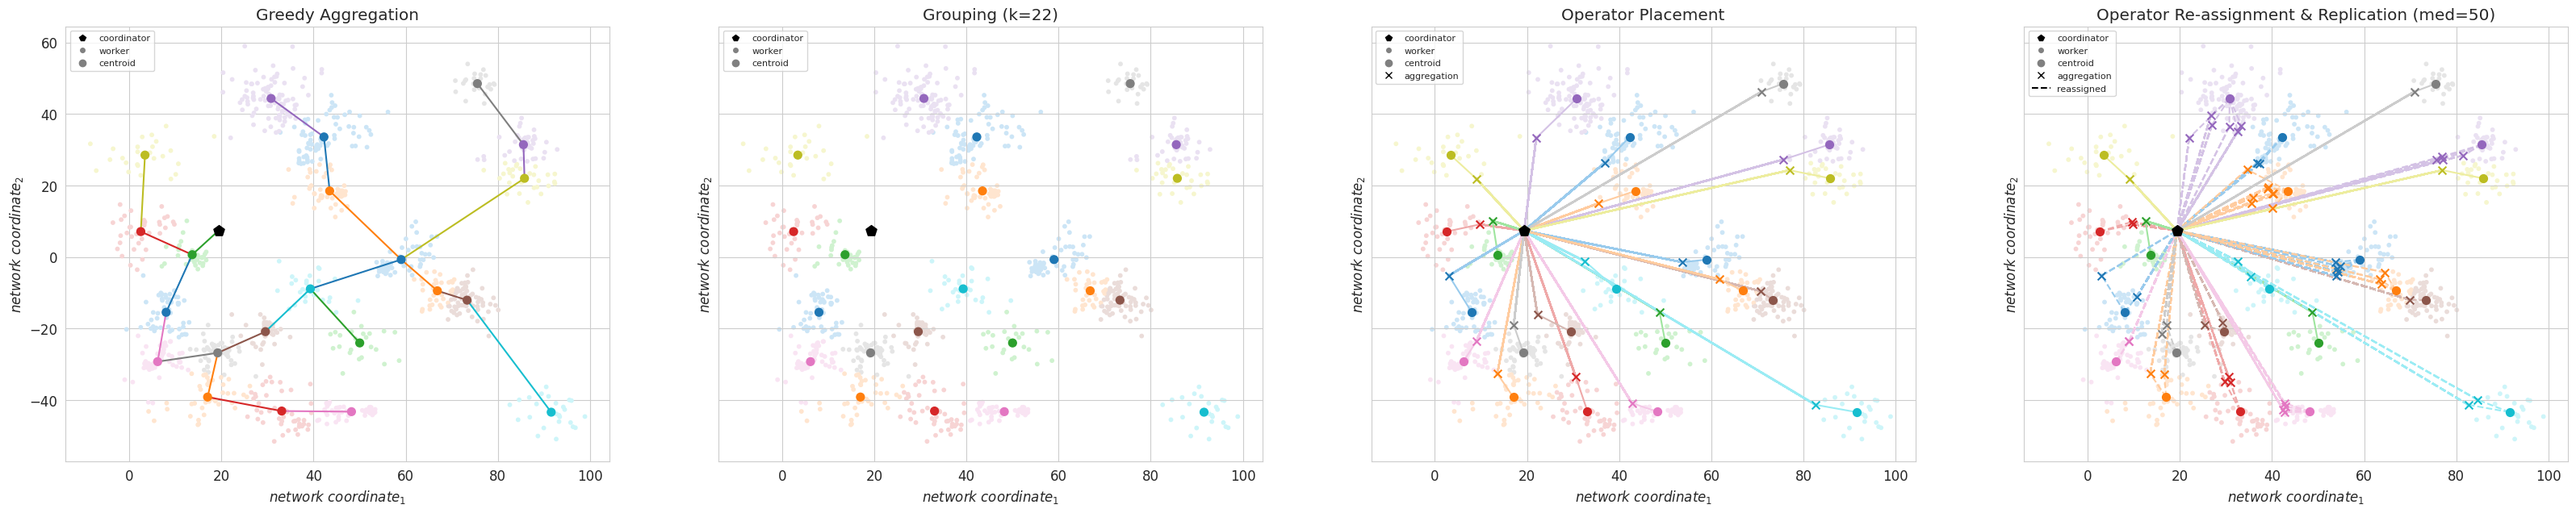

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)
ax2.set_title('Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot(ax3, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels,
          lval=lval)
util.plot(ax4, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels,
          changed_labels=reassigned_clussters, lval=lval)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Operator Placement")
ax4.set_title("Operator Re-assignment & Replication (med=" + med_label + ")")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

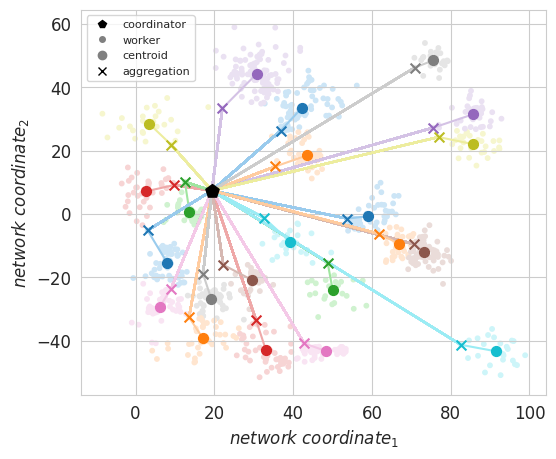

In [38]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(fig, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels,
          lval=lval)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  5.7942 %


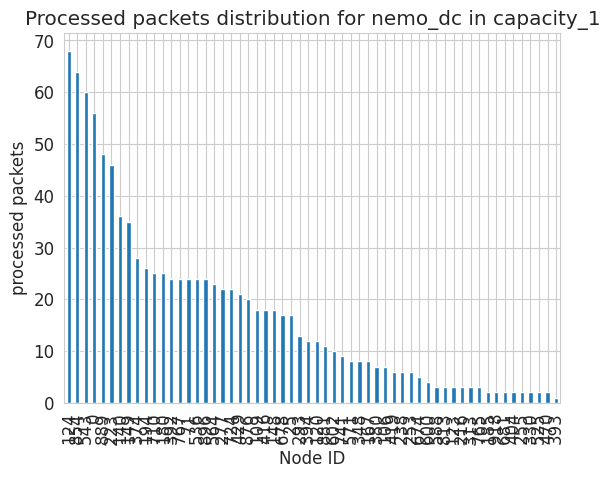

In [39]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 2c: NEMO Aggregation with Resource-based Penalty

In [40]:
prim_df

,x,y,latency,type,weight,base,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster
0,19.383905,7.406120,0.000000,coordinator,0,9223372036854775807,100,100,100,100,100,100,100,100,100,100,100,100,-1
1,67.743232,-14.007158,52.888118,worker,1,9223372036854775807,50,49,52,47,46,48,34,39,56,69,218,0,21
2,5.220579,-15.467092,26.903228,worker,1,9223372036854775807,50,52,54,55,48,51,46,34,27,30,16,11,20
3,43.521014,41.129903,41.471599,worker,1,9223372036854775807,50,49,53,60,55,69,66,29,61,25,59,21,0
4,14.195029,1.412734,7.927491,worker,2,9223372036854775807,50,51,50,44,41,65,33,34,66,39,22,7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,1,9223372036854775807,50,51,54,48,52,59,52,30,43,30,24,4,12
997,39.672067,34.499402,33.847532,worker,1,9223372036854775807,50,52,53,60,52,40,33,34,26,62,19,212,0
998,40.609309,23.985392,26.933066,worker,1,9223372036854775807,50,49,54,48,66,41,37,66,39,28,72,7,11
999,31.878351,34.859971,30.163307,worker,2,9223372036854775807,50,49,52,51,43,66,42,94,31,19,62,0,14


In [41]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

slot_col = "capacity_1"
med_label = first_med_label
eval_name = "nemo_pen"
df_dict_pen, eval_matrix[eval_name], agg_dict_pen, new_paths_pen = evaluate_nemo(prim_df, coords, centroids, W, L,
                                                                                    ["base"] + slot_columns, iterations=iterations, weighting="penalize")

Starting nemo for base with penalize
Starting nemo for capacity_100 with penalize
Starting nemo for capacity_90 with penalize
Starting nemo for capacity_80 with penalize
Starting nemo for capacity_70 with penalize
Starting nemo for capacity_60 with penalize
Starting nemo for capacity_50 with penalize
Starting nemo for capacity_40 with penalize
Starting nemo for capacity_30 with penalize
Starting nemo for capacity_20 with penalize
Starting nemo for capacity_10 with penalize
Starting nemo for capacity_5 with penalize
Starting nemo for capacity_1 with penalize


In [42]:
reassigned_clussters_pen = util.get_diff(agg_dict_pen["base"], agg_dict_pen[slot_col])
print(reassigned_clussters_pen)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21]


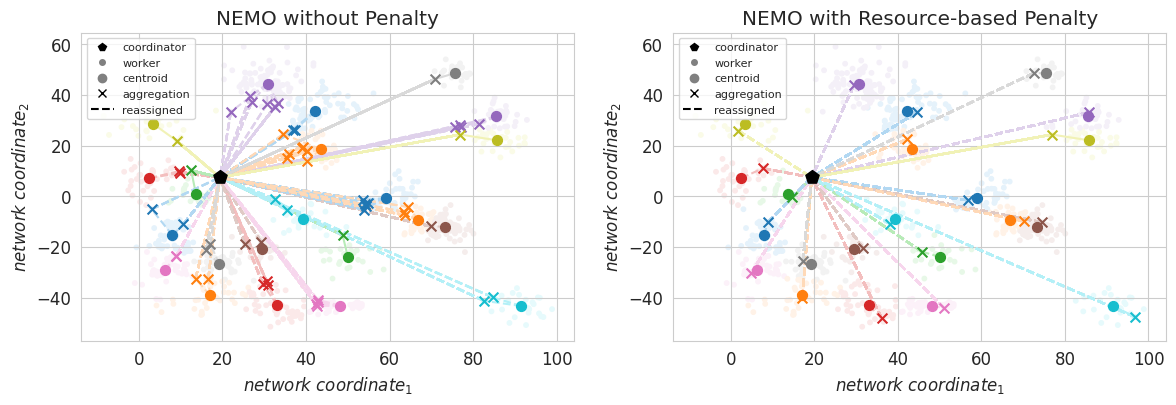

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
lval = 0.1

util.plot(ax1, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels,
          changed_labels=reassigned_clussters, lval=lval)

util.plot(ax2, new_paths_pen[slot_col], agg_dict_pen[slot_col], c_coords, cluster_coords, coords, colors, labels,
          changed_labels=reassigned_clussters_pen, lval=lval)

ax1.set_title('NEMO without Penalty')
ax2.set_title('NEMO with Resource-based Penalty')

plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [44]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:38773.0, valueBest:38773.0
i:10, t(i):3.49, valueNow:21609.0, valueBest:21605.0
i:20, t(i):1.22, valueNow:18333.0, valueBest:18333.0
i:30, t(i):0.42, valueNow:16736.0, valueBest:16736.0
i:40, t(i):0.15, valueNow:15484.0, valueBest:15484.0
i:50, t(i):0.05, valueNow:14773.0, valueBest:14773.0
i:60, t(i):0.02, valueNow:14298.0, valueBest:14298.0


In [45]:
print(route)

[ 10 739  31 ... 576 861 494]


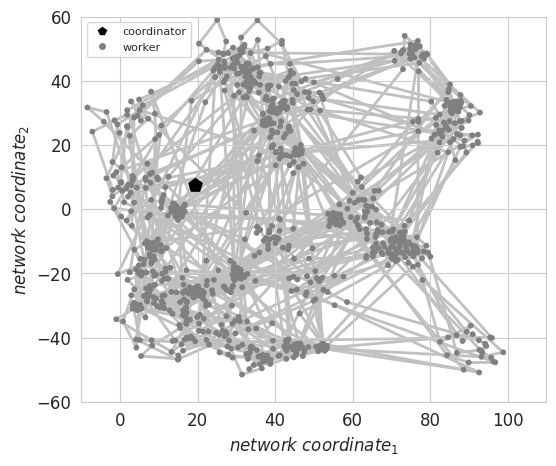

In [46]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/chain_50n.svg", bbox_inches="tight")
plt.show()

In [47]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  875  in route.


In [48]:
print(df_stats["received_packets"])

0       2.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
996     1.0
997     1.0
998     1.0
999     1.0
1000    1.0
Name: received_packets, Length: 1001, dtype: float64


count     1001.000000
mean      5464.971986
std       3747.344868
min          0.000000
25%       1714.539160
50%       5424.262914
75%       8643.277352
max      12290.854656
Name: latency_distribution, dtype: float64


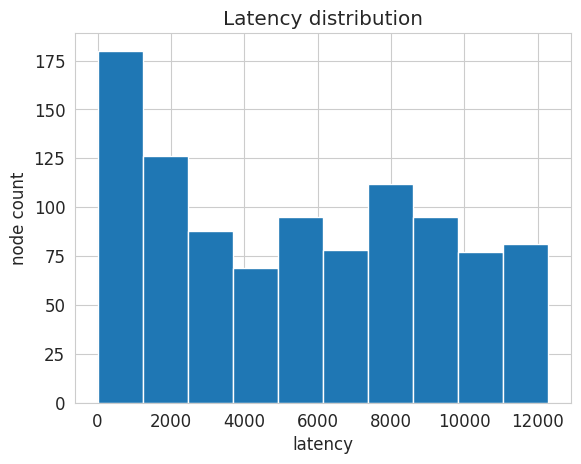

In [49]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    1001.000000
mean        0.999001
std         0.054763
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: received_packets, dtype: float64


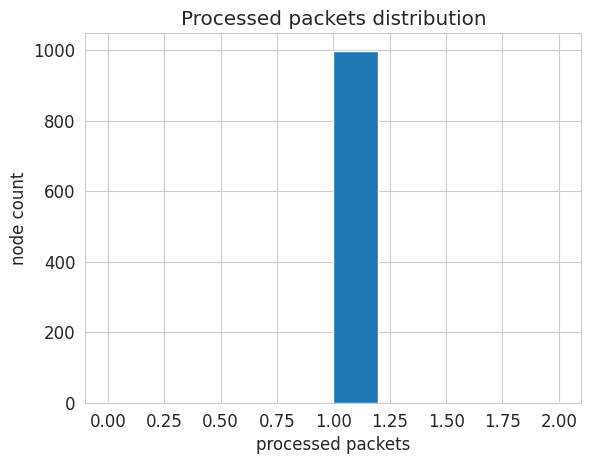

In [50]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [51]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [52]:
df = prim_df.copy()
mst = prim_mst(coords)

In [53]:
print(mst)

[-1, 570, 566, 645, 888, 297, 351, 557, 150, 917, 665, 86, 319, 725, 232, 108, 135, 453, 103, 591, 460, 256, 39, 268, 188, 253, 917, 83, 556, 982, 604, 310, 94, 909, 579, 338, 447, 421, 199, 229, 855, 184, 484, 110, 952, 689, 315, 477, 402, 139, 686, 489, 341, 828, 258, 5, 768, 748, 230, 211, 98, 249, 376, 450, 70, 564, 407, 52, 22, 549, 398, 525, 576, 700, 929, 155, 639, 879, 286, 411, 53, 983, 649, 259, 43, 300, 393, 768, 246, 280, 754, 384, 308, 821, 251, 661, 668, 533, 958, 664, 914, 377, 902, 706, 366, 559, 92, 822, 527, 876, 971, 759, 262, 807, 6, 620, 803, 226, 546, 964, 420, 218, 683, 999, 813, 409, 629, 615, 278, 960, 865, 26, 455, 32, 449, 870, 395, 743, 714, 946, 225, 99, 819, 691, 675, 603, 456, 110, 392, 896, 189, 445, 296, 724, 16, 84, 839, 410, 831, 87, 698, 780, 235, 901, 491, 15, 524, 681, 372, 541, 664, 853, 460, 217, 406, 631, 368, 589, 346, 615, 602, 134, 611, 114, 70, 551, 6, 127, 390, 431, 82, 378, 138, 801, 765, 122, 877, 727, 863, 627, 301, 693, 522, 292, 57, 91

In [54]:
routes = createRoutes(mst)
print(routes[3])

[645, 224, 344, 812, 222, 1000, 234, 116, 803, 670, 206, 355, 323, 360, 554, 495, 362, 37, 421, 850, 771, 787, 929, 766, 763, 599, 165, 15, 108, 527, 905, 510, 900, 365, 581, 994, 642, 985, 533, 582, 970, 418, 63, 450, 568, 939, 394, 416, 741, 507, 260, 973, 295, 632, 710, 933, 932, 881, 896, 441, 458, 577, 948, 845, 721, 545, 660, 695, 487, 993, 258, 718, 657, 326, 0]


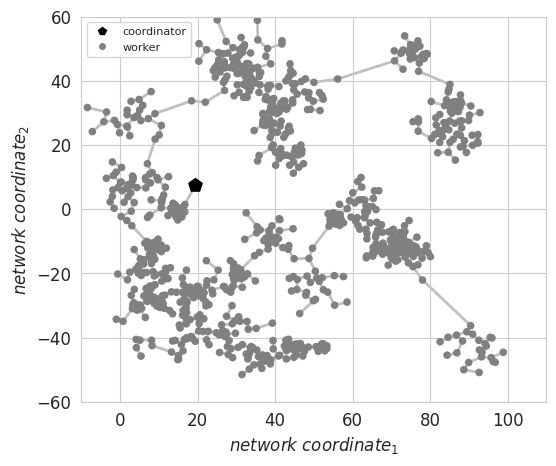

In [55]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/sim_1000/mst.svg", bbox_inches="tight")
plt.show()

In [56]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    1001.000000
mean      134.163517
std        57.300994
min         0.000000
25%        95.302957
50%       132.110373
75%       178.794881
max       277.576865
Name: latency_distribution, dtype: float64


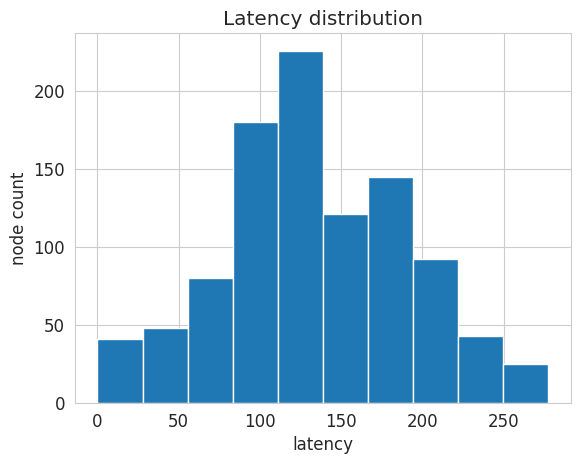

In [57]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  77.023 %


Text(0.5, 1.0, 'Processed packets distribution')

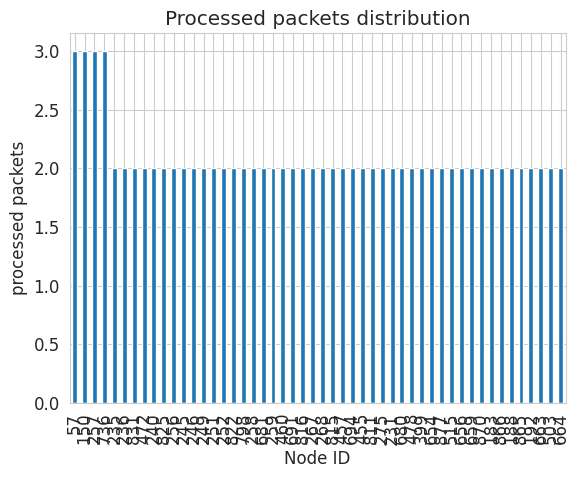

In [58]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [59]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [60]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_rc', 'nemo_dc', 'nemo_pen', 'chain', 'mst'])

In [68]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_rc', 'nemo_dc', 'nemo_pen']

#### Latency

In [69]:
heterogen_appr

['nemo_rc', 'nemo_dc', 'nemo_pen']

In [70]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8]
}


In [71]:
eval_matrix["dt"]["latency_distribution"].mean()

42.07131822601497

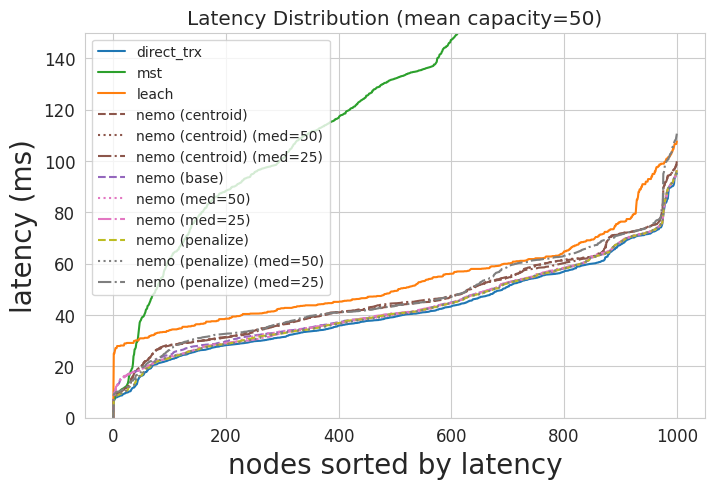

Means:  {'dt': 42.07, 'mst': 134.16, 'leach': 53.24, 'chain': 5464.97, 'nemo (centroid)': 46.27, 'nemo (centroid) (med=50)': 46.35, 'nemo (centroid) (med=25)': 46.31, 'nemo (med=50)': 43.51, 'nemo (med=25)': 43.55, 'nemo (penalize)': 43.15, 'nemo (penalize) (med=50)': 43.09, 'nemo (penalize) (med=25)': 47.14}
Quantiles:  {'dt': 67.35, 'mst': 215.28, 'leach': 76.41, 'chain': 10721.26, 'nemo (centroid)': 71.67, 'nemo (centroid) (med=50)': 71.83, 'nemo (centroid) (med=25)': 71.67, 'nemo (med=50)': 68.53, 'nemo (med=25)': 68.53, 'nemo (penalize)': 68.53, 'nemo (penalize) (med=50)': 68.53, 'nemo (penalize) (med=25)': 71.27}


In [92]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    elif l == "chain":
        continue
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for l in heterogen_appr:
    if l in ["nemo_dc", "nemo_rc", "nemo_pen"]:
        cl = l
        emat = eval_matrix[l]
        #print("Mean latency ", l, ": ", round(emat["capacity_50"]["latency_distribution"].mean(), 2))

        if l == "nemo_dc":
            l = "nemo"
        elif l == "nemo_rc":
            l = "nemo (centroid)"
        elif l == "nemo_pen":
            l = "nemo (penalize)"

        i = 0
        for k, df in emat.items():
            #if i % 50 == 0:
            if l == "nemo" and k == "base":
                sv = df["latency_distribution"].sort_values()
                sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[cl + "_base"], linestyle="--")
            elif k == "base":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l] = round(sv.quantile(0.9), 2)
                mean_dict[l] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl + "_base"], linestyle="--")
            elif k == "capacity_100":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l + " (med=" + first_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l + " (med=" + first_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l + " (med=" + first_med_label + ")", color=eval_colors[cl],
                        linestyle=":")
            elif k == "capacity_1":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l + " (med=" + last_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l + " (med=" + last_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[cl],
                        linestyle="-.")
            i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [93]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [94]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [95]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat["base"]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k + "_base"] = slot_list
        nn_dict[k + "_base"] = nn_list

In [96]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_rc', 'nemo_dc', 'nemo_pen', 'nemo_rc_base', 'nemo_dc_base', 'nemo_pen_base'])

In [97]:
agg_arr1 = []
for fam in heterogen_appr:
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
mr = np.mean(np.array(agg_arr1), axis=0)
load_dict["NEMO+redistribution"] = mr
print(mr)

agg_arr2 = []
for fam in heterogen_appr:
    agg_arr2.append(load_dict[fam + "_base"])
mr = np.mean(np.array(agg_arr2), axis=0)
load_dict["NEMO_base"] = mr
print(mr)

Fam:  nemo_rc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_pen
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 8.          6.66666667  7.66666667  7.66666667  7.33333333  8.
  7.          9.          9.33333333 10.         13.         11.33333333]


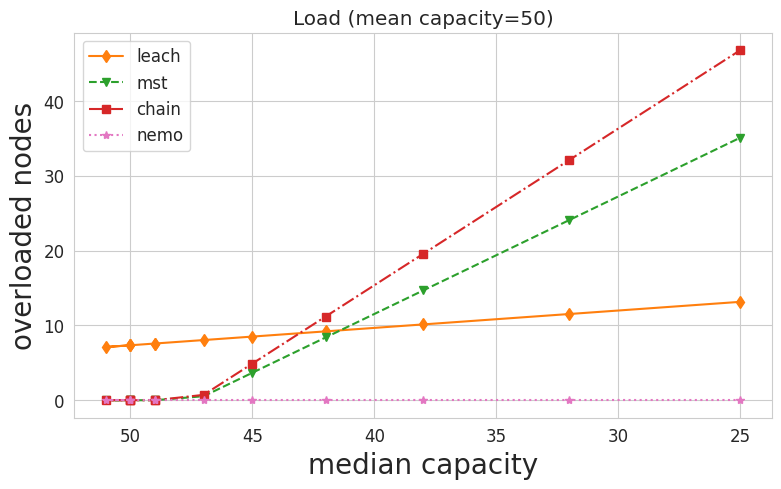

In [98]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution", "NEMO_base"]:
    vals = load_dict[fam]
    evcol = fam
    m, b = np.polyfit(medians, vals, 1)
    if fam == "sbon":
        fam = "sbon+NEMO_grouping"
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "NEMO+redistribution":
        fam = "nemo"
    if fam == "NEMO_base":
        fam = "nemo (base)"
        continue
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


leach - d #ff7f0e : [34.54545454545455, 33.40909090909091, 33.86363636363636, 33.18181818181818, 33.86363636363636, 35.45454545454545, 35.22727272727273, 38.18181818181819, 40.22727272727273, 45.22727272727272, 53.18181818181817, 60.45454545454546]
mst -- v #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.6]
chain -. s #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.408408408408409]
nemo : * #e377c2 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


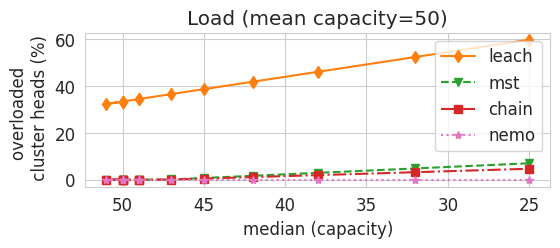

In [99]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution"]:
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "NEMO+redistribution":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/sim_1000/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [100]:
quant_dict

{'dt': 67.35,
 'mst': 215.28,
 'leach': 76.41,
 'chain': 10721.26,
 'nemo (centroid)': 71.67,
 'nemo (centroid) (med=50)': 71.83,
 'nemo (centroid) (med=25)': 71.67,
 'nemo (med=50)': 68.53,
 'nemo (med=25)': 68.53,
 'nemo (penalize)': 68.53,
 'nemo (penalize) (med=50)': 68.53,
 'nemo (penalize) (med=25)': 71.27}

In [101]:
mean_dict

{'dt': 42.07,
 'mst': 134.16,
 'leach': 53.24,
 'chain': 5464.97,
 'nemo (centroid)': 46.27,
 'nemo (centroid) (med=50)': 46.35,
 'nemo (centroid) (med=25)': 46.31,
 'nemo (med=50)': 43.51,
 'nemo (med=25)': 43.55,
 'nemo (penalize)': 43.15,
 'nemo (penalize) (med=50)': 43.09,
 'nemo (penalize) (med=25)': 47.14}